In [1]:
import os 
os.getcwd()

import warnings 
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt

train_eeg_dir = Path('../inputs/hms-harmful-brain-activity-classification/train_eegs')
train_spectrogram_dir = Path('../inputs/hms-harmful-brain-activity-classification/train_spectrograms/')

test_dtypes={
    "eeg_label_offset_seconds": "Int64", 
    "spectrogram_label_offset_seconds": "Int64",
    "expert_consensus": "category"
    }

train_df = pd.read_csv('../inputs/hms-harmful-brain-activity-classification/train.csv', dtype=test_dtypes)
display(train_df.head(10))

targets = train_df.columns[-6:] 
print(targets)

submission_df = pd.read_csv('../inputs/hms-harmful-brain-activity-classification/sample_submission.csv')
display(submission_df.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0,353733,0,0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6,353733,1,6,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8,353733,2,8,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18,353733,3,18,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24,353733,4,24,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26,353733,5,26,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30,353733,6,30,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36,353733,7,36,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40,353733,8,40,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0,924234,0,0,1978807404,30539,GPD,0,0,5,0,1,5


Index(['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote',
       'other_vote'],
      dtype='object')


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [10]:
train_df[train_df['eeg_id']==1461975533]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
70873,1461975533,0,0,1418215265,0,0,820051089,40881,Other,0,0,0,0,0,3


In [3]:
print("Unique eeg_id:", train_df['eeg_id'].nunique())
print("Unique label_id:", train_df['label_id'].nunique())
print("Unique spectrogram_id:", train_df['spectrogram_id'].nunique())
print("Unique patient_id:", train_df['patient_id'].nunique())

Unique eeg_id: 17089
Unique label_id: 106800
Unique spectrogram_id: 11138
Unique patient_id: 1950


In [ ]:
from scipy.stats import entropy
from scipy.special import rel_entr

def cal_entropy(row, apply_cols):
    nc = len(apply_cols)
    uniform_list = [1/nc for i in range(nc)]
    return sum(rel_entr(uniform_list, row[apply_cols].astype('float32').values + 1e-5))


In [ ]:
brain_activity = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
target_prob = [f"{lb}_prob" for lb in brain_activity]

train_df[target_prob] = train_df[targets].div(train_df[targets].sum(axis=1), axis=0)

train_df['entropy'] = train_df.apply(lambda x: cal_entropy(x, target_prob), axis=1)

display(train_df.head(10))

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
brain_activity = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']

counts, bins = np.histogram(train_df["entropy"],)
axes[0].stairs(counts, bins)
axes[0].set_xticks(np.arange(0, 8, 1), minor=True)
axes[0].grid(True)
axes[0].set_xlabel('Entropy')
axes[0].set_ylabel('Count')

thred = 5.5
small_group = train_df[train_df['entropy'] < thred]
lable_counts = small_group['expert_consensus'].value_counts() / small_group.shape[0]
lable_counts.plot(kind='bar', title='Small group', color='blue', grid=True, ax=axes[1])

large_group = train_df[train_df['entropy'] >= thred]
lable_counts = large_group['expert_consensus'].value_counts() / large_group.shape[0]
lable_counts.plot(kind='bar', title='Large group', color='blue', grid=True, ax=axes[2])

print("Small Entropy Group:", small_group.shape)
print("Large Entropy Group:", large_group.shape)

fig.tight_layout()
plt.show()

In [ ]:
df_agrees = train_df.groupby('eeg_id')['expert_consensus'].nunique().to_frame().reset_index(drop=False)
df_agrees = df_agrees.rename(columns={'expert_consensus': 'n_consensus'})
df_agrees = df_agrees.sort_values('n_consensus', ascending=False)
display(df_agrees.head(10))

In [ ]:
n_experts = train_df[targets].sum(axis=1)
n_experts.plot(kind='hist', title='Number of experts per sample', bins=10, color='blue', grid=True)

In [ ]:
small_group = train_df[n_experts < 7].copy()
large_group = train_df[n_experts >= 7].copy()

print("Small group:", small_group.shape)
print("Large group:", large_group.shape)

# plot count of expert_consensus
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
small_group.groupby('expert_consensus')['label_id'].count().plot(kind='bar', title='Small group', color='blue', grid=True, ax=ax[0])
large_group.groupby('expert_consensus')['label_id'].count().plot(kind='bar', title='Large group', color='blue', grid=True, ax=ax[1])
plt.show()

In [ ]:
from scipy.stats import entropy
from scipy.special import rel_entr

def get_non_overlap(df_csv, targets, group_key=['eeg_id'], calc_method='simple'):
    # Reference Discussion:
    # https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

    # train and validate using only 1 crop per eeg_id
    # Simple method:
    # - sum the votes for each label
    # - divide by the total number of votes
    # Weighted method:
    # - calculate the confidence for each label
    # - multiply the confidence by the votes for each label
    # - divide by the sum of the confidence for each label
    # - the confidence is calculated considering:
    #   - the number of votes for the label
    #   - the agreement between the experts

    def cal_entropy(row, tgt_list):
        nc = len(tgt_list)
        uniform_list = [1/nc for i in range(nc)]
        return sum(rel_entr(uniform_list, row[tgt_list].astype('float32').values + 1e-5))

    tgt_list = targets.tolist()
    brain_activity = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
    n_classes = len(brain_activity)

    def calc_confidence(row, n_max, n_classes):
        norm_weight = row['total_experts'] / n_max
        agreement = (row['vote_max'] - row['total_experts']/n_classes) / \
                    (row['total_experts'] - row['total_experts']/n_classes)
        return norm_weight * agreement

    def calc_weighted_votes(grp):

        n_experts_max = grp['total_experts'].max()
        grp['confidence'] = grp.apply(calc_confidence, axis=1, args=(n_experts_max, n_classes))
        grp['confidence_norm'] = grp['confidence'] / grp['confidence'].sum()

        weighted_votes = grp[tgt_list].multiply(grp['confidence_norm'], axis='index').sum()

        return weighted_votes

    agg_dict = {
        'spectrogram_id': 'first',
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'patient_id': 'first',
        'expert_consensus': 'first'
    }
    
    groupby = df_csv.groupby(group_key)
    train = groupby.agg(agg_dict)
    train.columns = ['_'.join(col).strip() for col in train.columns.values]
    train.columns = ['spectrogram_id', 'min', 'max', 'patient_id', 'target']

    if calc_method == 'simple':
        vote_sum = groupby[tgt_list].sum()
        class_probs = vote_sum.div(vote_sum.sum(axis=1), axis=0).reset_index(drop=False)

    elif calc_method == 'weighted':
        df_csv['total_experts'] = df_csv[[f"{label}_vote" for label in brain_activity]].sum(axis=1)
        df_csv['vote_max'] = df_csv[[f"{label}_vote" for label in brain_activity]].max(axis=1)
        weighted_votes = df_csv.groupby(group_key).apply(calc_weighted_votes, include_groups=False) 
        class_probs = weighted_votes.div(weighted_votes.sum(axis=1), axis=0).reset_index(drop=False)

    train = train.dropna()
    train = train.reset_index(drop=False)
    train = train.merge(class_probs, on=group_key, how='left')

    train["entropy"] = train.apply(cal_entropy, args=(tgt_list,), axis=1)
    
    return train

In [ ]:
train_df[train_df['eeg_id'] == 568657]

In [ ]:
# eeg_consensus = df_train_simple.groupby('eeg_id')['expert_consensus'].nunique() 
# eeg_consensus = eeg_consensus[eeg_consensus > 1]
# eeg_consensus = eeg_consensus.sort_values(ascending=False)

# eeg_consensus

In [ ]:
df_train_simple = get_non_overlap(train_df, targets, ['eeg_id', 'label_id'], calc_method='simple')

print(df_train_simple.shape)
display(df_train_simple.head(10))

display(df_train_simple[df_train_simple['eeg_id'] == 4284659653])

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
brain_activity = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
for i, ax in enumerate(axes.flatten()):
    label = brain_activity[i]
    sub_df = df_train_simple[df_train_simple['target'].str.lower() == label]
    sub_df['entropy'].plot(kind='hist', title=label, bins=10, color='blue', grid=True, ax=ax)
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Count')
    ax.set_title(label)

fig.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
brain_activity = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']

counts, bins = np.histogram(df_train_simple["entropy"],)
axes[0].stairs(counts, bins)
axes[0].set_xticks(np.arange(0, 8, 1), minor=True)
axes[0].grid(True)
axes[0].set_xlabel('Entropy')
axes[0].set_ylabel('Count')

thred = 5.5
small_group = df_train_simple[df_train_simple['entropy'] < thred]
lable_counts = small_group['target'].value_counts() / small_group.shape[0]
lable_counts.plot(kind='bar', title='Small group', color='blue', grid=True, ax=axes[1])

large_group = df_train_simple[df_train_simple['entropy'] >= thred]
lable_counts = large_group['target'].value_counts() / large_group.shape[0]
lable_counts.plot(kind='bar', title='Large group', color='blue', grid=True, ax=axes[2])

print("Small group:", small_group.shape)
print("Large group:", large_group.shape)

fig.tight_layout()
plt.show()

In [ ]:
df_train_simple = get_non_overlap(train_df, targets, 'eeg_id', calc_method='simple')
df_train_simple = df_train_simple.dropna()
print(df_train_simple.shape)
display(df_train_simple.head(10))

display(df_train_simple[df_train_simple['eeg_id'] == 4284659653])

In [ ]:
df_train_weighted = get_non_overlap(train_df, targets, ['eeg_id', 'spectrogram_id'], calc_method='weighted')

print(df_train_weighted.shape)
display(df_train_weighted.head(10))

display(df_train_weighted[df_train_weighted['eeg_id'] == 4284659653])

In [ ]:
td = df_train_weighted[df_train_weighted['eeg_id'] == 4284659653]
(td['min'] + td['max']) // 4

In [ ]:
fig, ax = plt.subplots(1, len(targets), figsize=(20, 4))
for i, tgt in enumerate(targets):
    ax[i].scatter(df_train_simple[tgt], df_train_weighted[tgt], alpha=0.5)
    ax[i].set_title(tgt)
    ax[i].set_xlabel('Simple')
    ax[i].set_ylabel('Weighted')

fig.tight_layout()
plt.show()

In [ ]:
small_train = df_train_simple[df_train_simple['eeg_id'].isin(small_group['eeg_id'])]
large_train = df_train_simple[df_train_simple['eeg_id'].isin(large_group['eeg_id'])]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for col in targets:
    small_train.hist(col, bins=10, ax=ax[0], histtype='step', grid=True, label=col)
    large_train.hist(col, bins=10, ax=ax[1], histtype='step', grid=True, label=col)
ax[0].set_title('Small group')
ax[1].set_title('Large group')
ax[0].legend()
ax[1].legend()
plt.show()

In [5]:
eeg_id = 1461975533
eeg_df = pd.read_parquet(train_eeg_dir/f"{eeg_id}.parquet")
print(eeg_df.shape)
eeg_df

(10000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,16390.449219,4982.399902,5671.609863,4467.729980,4780.850098,5706.990234,5145.740234,4746.470215,6988.290039,7869.830078,4588.350098,-814.840027,4541.750000,820.590027,4412.569824,2091.239990,5906.220215,5444.500000,4914.439941,697.950012
1,24649.550781,-2653.090088,-2907.360107,-2704.949951,-4969.959961,-3290.139893,-2757.699951,-2782.300049,4849.779785,1256.770020,-2566.610107,20844.529297,-2709.989990,-2329.959961,-2665.879883,1929.010010,-2559.100098,-3890.209961,-4920.290039,40.340000
2,8468.919922,8144.720215,7541.129883,8370.889648,6978.930176,7351.509766,7914.680176,7969.390137,-10492.049805,19776.769531,8391.929688,12917.919922,8385.919922,1245.969971,8434.910156,-2962.469971,7541.040039,7016.549805,5617.410156,-358.809998
3,20336.869141,9681.009766,10173.209961,9240.349609,9708.639648,10213.870117,9766.769531,9303.969727,1164.619995,11992.349609,9303.549805,383.700012,9363.129883,2250.540039,9227.690430,230.770004,10311.549805,10058.500000,8810.139648,530.270020
4,40109.640625,-3335.379883,-3121.510010,-3560.169922,-4801.709961,-3350.179932,-3220.879883,-3329.330078,9404.459961,5162.569824,-3392.479980,18802.820312,-3548.189941,-2004.339966,-3564.929932,3219.620117,-2530.699951,-3628.139893,-4079.370117,354.119995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,21894.869141,1424.209961,1186.750000,1030.010010,2298.270020,1614.760010,1690.819946,387.049988,1209.670044,5201.839844,1172.979980,6988.700195,985.880005,602.770020,879.650024,3036.820068,1569.359985,1719.380005,2058.399902,872.299988
9996,8078.520020,-13209.000000,-11357.440430,-13104.309570,-13244.299805,-11363.500000,-13077.559570,-10960.500000,8975.950195,10251.290039,-13060.200195,-736.169983,-13186.839844,-3489.129883,-13115.830078,3407.739990,-11230.790039,-11235.009766,-10345.250000,-34.240002
9997,19378.330078,9063.410156,5235.660156,9390.209961,8354.570312,4826.870117,8758.000000,5844.279785,-13593.290039,-13210.690430,9304.400391,25358.269531,9515.410156,1465.660034,9587.469727,-5029.990234,4897.660156,4705.390137,3729.639893,-765.950012
9998,24185.439453,957.200012,7236.850098,690.109985,1553.160034,7573.779785,1103.810059,6553.870117,2668.530029,-57.939999,775.190002,11383.690430,667.869995,2438.520020,575.479980,-71.900002,7488.709961,7560.020020,7308.919922,608.840027


In [21]:
spec_id = 381128509
spec_df = pd.read_parquet(train_spectrogram_dir/f"{spec_id}.parquet")
print(spec_df.shape)
spec_df

(398, 401)


,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,6943.310059,16547.269531,36761.238281,80740.898438,93584.468750,82484.992188,61268.039062,28341.359375,20165.080078,...,20907.009766,19652.550781,36803.171875,58513.371094,47141.359375,48036.039062,43840.671875,12610.349609,13857.910156,18479.210938
1,3,5444.859863,12879.190430,64691.808594,75376.953125,99603.023438,109966.726562,50173.070312,41908.488281,27530.720703,...,25477.460938,20669.250000,38336.910156,51249.878906,64824.898438,57630.000000,38195.089844,10678.269531,16615.740234,24654.369141
2,5,5607.129883,20358.910156,52815.429688,84891.218750,126897.757812,117560.203125,84890.492188,76443.007812,15967.870117,...,17670.810547,16409.589844,34992.148438,58253.300781,53960.980469,54746.238281,42907.261719,25427.849609,22474.669922,26973.910156
3,7,28201.019531,41902.878906,41828.398438,40703.179688,82135.976562,68191.398438,70717.507812,72063.429688,42986.121094,...,28468.060547,22874.849609,39718.140625,38273.519531,34399.679688,35385.578125,32988.820312,35405.078125,34820.769531,35295.421875
4,9,27066.320312,44361.578125,48786.570312,43296.898438,75652.578125,57967.171875,68989.328125,67209.601562,29240.919922,...,30448.009766,16195.230469,64403.960938,50745.781250,44536.171875,52405.628906,23971.250000,31090.720703,28299.140625,23265.279297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,787,46698.031250,49401.980469,86877.156250,42167.578125,54483.441406,69109.171875,42231.148438,34771.988281,39717.351562,...,25298.820312,24294.679688,18516.560547,32791.218750,55340.460938,42819.140625,64757.191406,111465.429688,76164.468750,77782.656250
394,789,29160.810547,32711.699219,22735.730469,28422.390625,28689.109375,22454.929688,16842.220703,16248.290039,16536.150391,...,14869.349609,20489.089844,18236.750000,22959.650391,26143.439453,36879.121094,55830.921875,106236.500000,92324.812500,105294.367188
395,791,11491.959961,12790.250000,14089.120117,14953.639648,15260.309570,17436.109375,17068.750000,15809.750000,15936.089844,...,10344.870117,10220.969727,10379.530273,18456.279297,11426.790039,16980.439453,49382.929688,73370.289062,118573.468750,142199.312500
396,793,8332.780273,9551.809570,9733.559570,11694.419922,13155.509766,13070.450195,11737.389648,11982.719727,14726.370117,...,7334.709961,8801.290039,10083.000000,9171.629883,7764.839844,8765.959961,18818.769531,74045.273438,123743.296875,148475.812500


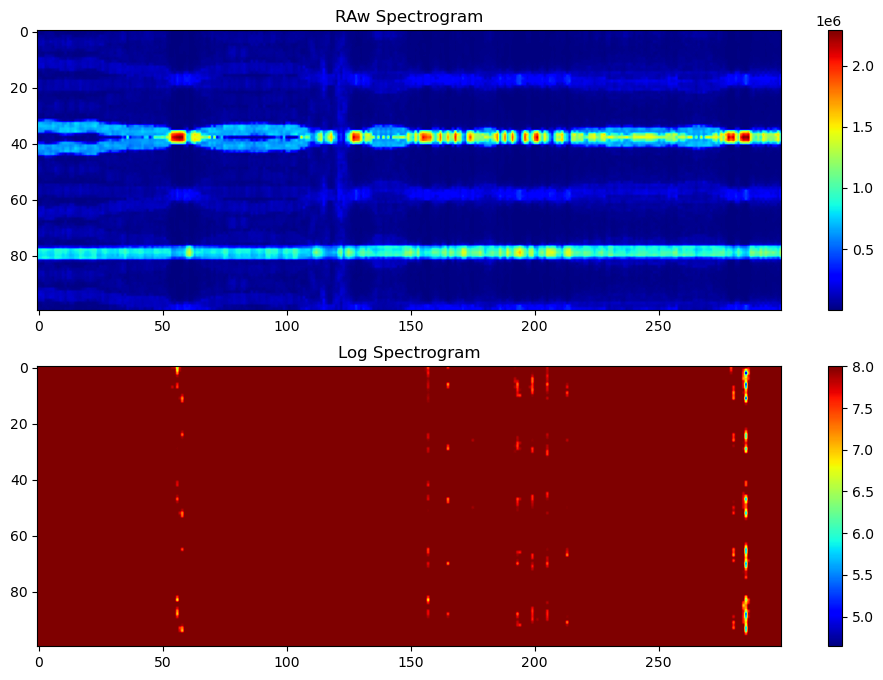

In [22]:
spectrogram = spec_df.iloc[0:300, 1:101].values.astype('float32').T 

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
im = axes[0].imshow(spectrogram, aspect='auto', cmap='jet')
fig.colorbar(im, ax=axes[0])
axes[0].set_title('RAw Spectrogram')
spectrogram = np.clip(spectrogram, np.exp(-4), np.exp(8))
im = axes[1].imshow(np.log(spectrogram), aspect='auto', cmap='jet')
fig.colorbar(im, ax=axes[1])
axes[1].set_title('Log Spectrogram')
plt.show()

In [8]:
def load_eeg_and_spectrogram(eeg_id, spec_id, eeg_offset, spec_offset):

    eeg_df = pd.read_parquet(train_eeg_dir/f"{eeg_id}.parquet")
    start_eeg = eeg_offset * 200
    end_eeg = start_eeg + (200 * 50)

    eeg = eeg_df.iloc[start_eeg:end_eeg,]

    spec_df = pd.read_parquet(train_spectrogram_dir/f"{spec_id}.parquet")
    start_spec = spec_offset
    end_spec = start_spec + 600

    spec = spec_df[(spec_df["time"] <= end_spec) & (spec_df["time"] >= start_spec)]

    return eeg, spec

from scipy.signal import butter, sosfilt

sos = butter(4, [1, 40], btype="bandpass", fs=200, output='sos')

def central_window_eeg(df, window_seconds=10):
    start = df.index[0]
    end = df.index[-1]
    mid = (start + end) / 2
    new_start = int(mid - window_seconds/2 * 200) - start + 1
    new_end = int(mid + window_seconds/2 * 200) - start + 1
    return df.iloc[new_start:new_end]

def plot_eeg(df, bp_filter=True):

    fig, axs = plt.subplots(20, 1, figsize=(15, 10), sharex=True)
    
    for i, ax in enumerate(axs):
        
        if bp_filter:
            ts_signal = sosfilt(sos, df.iloc[:,i])
        else:
            ts_signal = df.iloc[:,i]

        ax.plot(ts_signal, color="black")
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
    
    fig.tight_layout()
    plt.show()

def plot_spec(df):

    fig, axs = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

    prefixes = ['LL', 'RL', 'LP', 'RP']

    for ax, prefix in zip(axs.flatten(), prefixes):
        cols = df.filter(regex=f"^{prefix}_").columns
        ax.imshow(df[cols].T, origin="lower", norm="log", cmap="plasma", interpolation="none")
        ax.set_title(prefix, fontsize=12, fontweight="bold")
        ax.set_yticks(np.arange(0, 101, 25.))
        ax.set_yticklabels([0, 5, 10, 15, 20])
        ax.set_xticks(np.arange(0, 301, 75.))
        ax.set_xticklabels(range(df.iloc[0, 0], df.iloc[-1, 0], (df.iloc[-1, 0]-df.iloc[0, 0])//4))

    for ax in axs[:, 0]:
        ax.set_ylabel("Frequency (Hz)")
    for ax in axs[-1, :]:
        ax.set_xlabel("Time (s)")

    fig.tight_layout()
    plt.show()

In [ ]:
choose_row = 2387

eeg_id, spec_id, eeg_offset, spec_offset = train_df.loc[choose_row, ['eeg_id', 'spectrogram_id', 'eeg_label_offset_seconds', 'spectrogram_label_offset_seconds']]

votes = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote" ]

print(f"eeg_id: {eeg_id}, spec_id: {spec_id}, eeg_offset: {eeg_offset}, spec_offset: {spec_offset}")
print(f"patient_id: {train_df.loc[choose_row, 'patient_id']}")
print(f"label_id: {train_df.loc[choose_row, 'label_id']}")
print(f"expert_consensus: {train_df.loc[choose_row, 'expert_consensus']}")
print(f"Votes: ")
for vote in votes:
    print(f"{vote}: {train_df.loc[choose_row, vote]}")


df_eeg, df_spec = load_eeg_and_spectrogram(eeg_id, spec_id, eeg_offset, spec_offset)

In [ ]:
df_eeg.head(20)

In [ ]:
df_spec.head(20)

In [ ]:
LL_freq = df_spec.filter(regex="^LL_")
LL_freq.head()

In [ ]:
plot_eeg(central_window_eeg(df_eeg, 10), bp_filter=True)

In [ ]:
plot_spec(df_spec)

In [ ]:
arr_spec = df_spec.iloc[:, 1:].to_numpy().T
arr_spec.shape

In [ ]:
from torchvision.transforms import v2
from torchvision.transforms import functional as F
import torch
import random

class MyCustomTransform(torch.nn.Module):
    def __init__(self, mask_ratio=0.1, max_mask_num=2):
        super(MyCustomTransform, self).__init__()
        self.mask_ratio = mask_ratio
        self.max_mask_num = max_mask_num
    
    def forward(self, image):

        # Assuming image is a tensor of shape [C, H, W]
        _, h, w = image.shape
        
        for _ in range(random.randint(1, self.max_mask_num)):
            image = self._apply_mask(image, h, w)

        return image

    def _apply_mask(self, image, h, w):

        # Calculate max mask width and height based on mask_ratio
        max_mask_width = int(w * self.mask_ratio)
        max_mask_height = int(h * self.mask_ratio)
        
        # Randomly choose the dimension(s) to mask: 0 for cols, 1 for rows, 2 for both
        dim_to_mask = random.randint(0, 2)
        
        # Initialize mask as ones
        mask = torch.ones_like(image)
        
        # Select random start point for masking in both dimensions
        x1 = random.randint(0, w - max_mask_width)
        y1 = random.randint(0, h - max_mask_height)
        
        # Calculate end points ensuring they do not exceed max mask width/height
        x2 = x1 + random.randint(1, max_mask_width)
        y2 = y1 + random.randint(1, max_mask_height)
        
        # Adjust x2 and y2 to not go beyond image bounds
        x2 = min(x2, w)
        y2 = min(y2, h)
        
        if dim_to_mask == 0 or dim_to_mask == 2:
            mask[:, :, x1:x2] = 0
        
        if dim_to_mask == 1 or dim_to_mask == 2:
            mask[:, y1:y2, :] = 0
        
        image_new = image * mask
        
        return image_new


applier = v2.RandomApply(
    transforms=[
        v2.RandomHorizontalFlip(p=.2),
        v2.RandomVerticalFlip(p=.2),
        MyCustomTransform(mask_ratio=0.1)
        ], p=.5)


fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axs[0, 0].imshow(arr_spec, origin="lower", norm="log", cmap="plasma", interpolation="none")
axs[0, 0].set_title("Original")
for i, ax in enumerate(axs.flatten()[1:]):
    arr_spec_transformed = applier(torch.tensor(np.expand_dims(arr_spec, axis=0))).numpy()
    ax.imshow(arr_spec_transformed[0], origin="lower", norm="log", cmap="plasma", interpolation="none")
    ax.set_title(f"Transformed {i+1}")

fig.tight_layout()
plt.show()